In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa import api 
from statsmodels.tsa.api import ExponentialSmoothing , SimpleExpSmoothing 
from statsmodels.tsa.arima_model import ARIMA
import scipy
from scipy.optimize import minimize 
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

### 1. 데이터 불러오기

In [2]:
#CSV 파일 불러오기
selloutData = pd.read_csv('../dataset/sample_kopo.csv')
# 컬럼해더 재정의
selloutData.columns = selloutData.columns.str.upper()
# 데이터 VIEW
selloutData.head()

,YEAR,MONTH,REGION,SUBSIDIARY,PRODUCT,BRAND,MODEL,MODEL_GROUP,CAPA,FEATURE,SALES_QTY,SALES_PRICE,MON
0,2015,JAN,Europe,SUBSIDIARY1,PRODUCT1,BRAND1,MODEL0895,MODELG0876,-,FEATURE1,103,97084,1
1,2015,FEB,Europe,SUBSIDIARY1,PRODUCT1,BRAND1,MODEL0895,MODELG0876,-,FEATURE1,60,52861,2
2,2015,MAR,Europe,SUBSIDIARY1,PRODUCT1,BRAND1,MODEL0895,MODELG0876,-,FEATURE1,172,150478,3
3,2015,APR,Europe,SUBSIDIARY1,PRODUCT1,BRAND1,MODEL0895,MODELG0876,-,FEATURE1,145,121392,4
4,2015,MAY,Europe,SUBSIDIARY1,PRODUCT1,BRAND1,MODEL0895,MODELG0876,-,FEATURE1,71,61763,5


In [3]:
selloutData.dtypes

YEAR            int64
MONTH          object
REGION         object
SUBSIDIARY     object
PRODUCT        object
BRAND          object
MODEL          object
MODEL_GROUP    object
CAPA           object
FEATURE        object
SALES_QTY       int64
SALES_PRICE     int64
MON             int64
dtype: object

### 2. 데이터 필터 및 정렬

In [4]:
sortKey = ["SUBSIDIARY","PRODUCT","MODEL","YEAR","MON"]

# 오름차순정렬
sortedData = selloutData.sort_values(sortKey)
sortedData.reset_index(drop=True,inplace=True)
sortedData.head()

,YEAR,MONTH,REGION,SUBSIDIARY,PRODUCT,BRAND,MODEL,MODEL_GROUP,CAPA,FEATURE,SALES_QTY,SALES_PRICE,MON
0,2017,APR,Europe,SUBSIDIARY1,PRODUCT1,BRAND2,MODEL0001,MODELG0001,267,FEATURE2,1,1271,4
1,2017,APR,Europe,SUBSIDIARY1,PRODUCT1,BRAND2,MODEL0002,MODELG0002,268,FEATURE2,10,8498,4
2,2017,APR,Europe,SUBSIDIARY1,PRODUCT1,BRAND2,MODEL0005,MODELG0005,266,FEATURE2,2,2023,4
3,2017,APR,Europe,SUBSIDIARY1,PRODUCT1,BRAND2,MODEL0008,MODELG0008,264,FEATURE2,1,1311,4
4,2014,JAN,Europe,SUBSIDIARY1,PRODUCT1,BRAND2,MODEL0013,MODELG0013,348,FEATURE1,1,690,1


In [5]:
def groupCountDf(eachGroup):

    #eachGroup = groupData.get_group(list(groupData.groups)[5])

    eachGroup["KNOB"] = eachGroup["SALES_QTY"].count()

    return eachGroup

In [7]:
groupKey = ["SUBSIDIARY","PRODUCT","MODEL"]
groupResult = sortedData.groupby(groupKey).apply(groupCountDf)

In [8]:
groupResult.head()

,YEAR,MONTH,REGION,SUBSIDIARY,PRODUCT,BRAND,MODEL,MODEL_GROUP,CAPA,FEATURE,SALES_QTY,SALES_PRICE,MON,KNOB
0,2017,APR,Europe,SUBSIDIARY1,PRODUCT1,BRAND2,MODEL0001,MODELG0001,267,FEATURE2,1,1271,4,1
1,2017,APR,Europe,SUBSIDIARY1,PRODUCT1,BRAND2,MODEL0002,MODELG0002,268,FEATURE2,10,8498,4,1
2,2017,APR,Europe,SUBSIDIARY1,PRODUCT1,BRAND2,MODEL0005,MODELG0005,266,FEATURE2,2,2023,4,1
3,2017,APR,Europe,SUBSIDIARY1,PRODUCT1,BRAND2,MODEL0008,MODELG0008,264,FEATURE2,1,1311,4,1
4,2014,JAN,Europe,SUBSIDIARY1,PRODUCT1,BRAND2,MODEL0013,MODELG0013,348,FEATURE1,1,690,1,1


In [11]:
maxKnob = groupResult["KNOB"].max()
maxKnob

40

### 최대 maxKnob 존재 데이터만 필터링

In [12]:
refinedData = groupResult[groupResult.KNOB >= maxKnob]

refinedData["YEARMON"] = refinedData["YEAR"].astype(str) +  refinedData["MON"].astype(str).str.zfill(2)

C:\Users\kopo\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
refinedData.head()

,YEAR,MONTH,REGION,SUBSIDIARY,PRODUCT,BRAND,MODEL,MODEL_GROUP,CAPA,FEATURE,SALES_QTY,SALES_PRICE,MON,KNOB,YEARMON
208,2014,JAN,Europe,SUBSIDIARY1,PRODUCT1,BRAND1,MODEL0037,MODELG0037,264,FEATURE4,78,66839,1,40,201401
209,2014,FEB,Europe,SUBSIDIARY1,PRODUCT1,BRAND1,MODEL0037,MODELG0037,264,FEATURE4,71,62273,2,40,201402
210,2014,MAR,Europe,SUBSIDIARY1,PRODUCT1,BRAND1,MODEL0037,MODELG0037,264,FEATURE4,77,69258,3,40,201403
211,2014,APR,Europe,SUBSIDIARY1,PRODUCT1,BRAND1,MODEL0037,MODELG0037,264,FEATURE4,62,55437,4,40,201404
212,2014,MAY,Europe,SUBSIDIARY1,PRODUCT1,BRAND1,MODEL0037,MODELG0037,264,FEATURE4,76,68938,5,40,201405


### 3. ets 머신러닝 사용

In [14]:
# pip install --upgrade --no-deps statsmodels stats모델 업데이트
# mul: 데이터 흐름이 비선형형태. 곱셉 방식의 증가 
# add: 데이터 흐름이 선형형태. 덧셈 방식의 증가
# 계절성 옵션 seasonal_periods: 12개월로 정함
# 지수평활화의 함수에선 시계열의 흐름과 특징이 맞지 않으면 자동으로 인덱스 오류 발생

In [15]:
YEARMON_STD = 201601

In [16]:
def sub_function(data):
   #그룹바이 다음에 바로 apply(sub_function)이 들어갈거기때문에 맨첫줄에 reset_index 
    data.reset_index(inplace=True,drop=True)
    ########################################2017년기준으로 train ,test 데이터 분리##
    trainData = data[data["YEARMON"].astype(int)<YEARMON_STD].reset_index(drop = True)
    testData = data[data["YEARMON"].astype(int)>=YEARMON_STD].reset_index(drop = True)
    trainCount = len(trainData)
    testCount = len(testData)
    y =  trainData[['SALES_QTY']].astype(float)
    M = 'multiplicative'
    #######################################모델적용############################################
    ets_model = ExponentialSmoothing(y.values,  trend=None, seasonal=M,  seasonal_periods=12 )
    #Holt(y.values)
    ets_fit = ets_model.fit(optimized='True')

    yhPredict = ets_fit.predict(start=trainCount+1,end=trainCount+testCount)
    ###############예측데이터 데이터프레임화 후 testData에 밀어넣음##############################
    yh = pd.DataFrame(data = yhPredict,columns = ["predict"])
    testData["PREDICT"] = yh
    
    #input값으로 들어온 데이터 수랑 return으로 보내는 testData는 수가 다른데 리턴값에 따라 데이터프레임 변형되도 상관없는듯.
    return testData

In [17]:
forecastData = refinedData.groupby(groupKey).apply(sub_function).reset_index(drop=True)

C:\Users\kopo\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Users\kopo\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Users\kopo\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Users\kopo\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Users\kopo\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Users\kopo\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle

In [18]:
forecastData

,YEAR,MONTH,REGION,SUBSIDIARY,PRODUCT,BRAND,MODEL,MODEL_GROUP,CAPA,FEATURE,SALES_QTY,SALES_PRICE,MON,KNOB,YEARMON,PREDICT
0,2016,JAN,Europe,SUBSIDIARY1,PRODUCT1,BRAND1,MODEL0037,MODELG0037,264,FEATURE4,2,1130,1,40,201601,15.847947
1,2016,FEB,Europe,SUBSIDIARY1,PRODUCT1,BRAND1,MODEL0037,MODELG0037,264,FEATURE4,4,2529,2,40,201602,7.664328
2,2016,MAR,Europe,SUBSIDIARY1,PRODUCT1,BRAND1,MODEL0037,MODELG0037,264,FEATURE4,1,650,3,40,201603,7.703076
3,2016,APR,Europe,SUBSIDIARY1,PRODUCT1,BRAND1,MODEL0037,MODELG0037,264,FEATURE4,12,8108,4,40,201604,9.869959
4,2016,MAY,Europe,SUBSIDIARY1,PRODUCT1,BRAND1,MODEL0037,MODELG0037,264,FEATURE4,10,7363,5,40,201605,7.727425
5,2016,JUN,Europe,SUBSIDIARY1,PRODUCT1,BRAND1,MODEL0037,MODELG0037,264,FEATURE4,28,19694,6,40,201606,10.243098
6,2016,JUL,Europe,SUBSIDIARY1,PRODUCT1,BRAND1,MODEL0037,MODELG0037,264,FEATURE4,29,20460,7,40,201607,6.733993
7,2016,AUG,Europe,SUBSIDIARY1,PRODUCT1,BRAND1,MODEL0037,MODELG0037,264,FEATURE4,38,23425,8,40,201608,8.236410
8,2016,SEP,Europe,SUBSIDIARY1,PRODUCT1,BRAND1,MODEL0037,MODELG0037,264,FEATURE4,49,29044,9,40,201609,7.790297
9,2016,OCT,Europe,SUBSIDIARY1,PRODUCT1,BRAND1,MODEL0037,MODELG0037,264,FEATURE4,52,30669,10,40,201610,12.010354


### 4. 그룹바이 디버깅 시각화

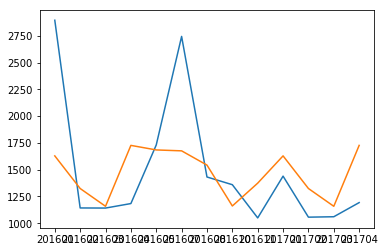

In [19]:
groupNewcustomerData = forecastData.groupby(groupKey)

len(groupNewcustomerData)

#14개의 그룹중 첫번째 그룹을 가져옴
eachGroup = groupNewcustomerData.get_group(list(groupNewcustomerData.groups)[27])

#치솟는 값이 있어서 시각화가힘들어져 걸러냄
eachGroup1 =eachGroup[eachGroup['PREDICT']<2000]

#실제값과 예측값 시각화 비교
plt.plot(eachGroup1['YEARMON'],eachGroup1['SALES_QTY'])
plt.plot(eachGroup1['YEARMON'],eachGroup1['PREDICT'])
plt.show()

### 5. 정확도 측정

In [21]:
mean_squared_error(forecastData['SALES_QTY'], forecastData['PREDICT'])

80908.24523633248

In [22]:
mean_absolute_error(forecastData['SALES_QTY'], forecastData['PREDICT'])

143.62598457080233

### 6. csv로 내보내기

In [23]:
#forecastData.to_csv('ets.csv',index = False)